<a href="https://colab.research.google.com/github/mbcruz96/Canny-Edge-Detection/blob/main/Canny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

#Importing Image

<function matplotlib.pyplot.show(close=None, block=None)>

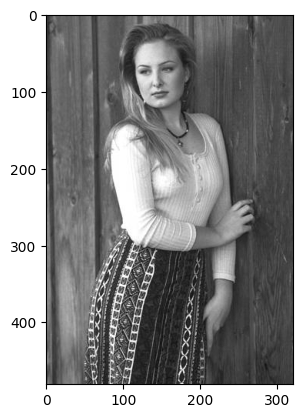

In [ ]:
path = 'Hw1-gray-scale3.jpg'
I = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.imshow(I, cmap='gray')
plt.show

#Guassian filter

In [ ]:
def gaussian_kernel(sigma=1):
  '''
  Computes normalized 1D Gaussian kernel
  Input: # of standard deviations
  Size: 5 (fixed)
  Return: 1x5 array

  '''
  # calculating gaussian parameters
  size = 5  # constant gaussian size
  vals = math.floor(size/2)
  normal = np.sqrt(2.0 * np.pi * sigma**2)
  filter = []

  # calculating gaussian filter
  for i in range(-vals, vals+1):
    filter.append(np.exp(-((i ** 2) / (2.0 * (sigma**2))))/ normal)
  filter = np.array(filter)
  return np.array(filter)



In [ ]:
def gaussian_derivative_kernel(sigma=1):
  '''

  Computes normalized 1D Gaussian first derivative kernel
  Input: # of standard deviations
  Return: 1x5 array

  '''
  # calculating gaussian parameters
  size = 5  # constant gaussian size
  vals = math.floor(size/2)
  normal = np.sqrt(2.0 * np.pi * sigma**2)
  filter = []

  # calculating gaussian filter
  for i in range(-vals, vals+1):
    filter.append((-(i/sigma**2) * (np.exp(-(i ** 2) / (2.0 * (sigma**2))))) / normal)
  filter = np.array(filter)
  return np.array(filter)

# Convolution

In [ ]:
def convolution(image, kernel):
  '''
  Convolves an image matrix with a kernel
  Inputs:
    - mxn image matrix
    - 1D kernel
  Output: tuple T = (Ix, Iy)
    - Ix: mxn matrix of convolutions in x direction
    - Iy: mxn matrix of convolutions in y direction

  '''
  # creating new padded image and matrices for filtering in x and y directions
  padding = math.floor(len(kernel)/2)
  new_image = np.pad(image, ((padding, padding), (padding, padding)), 'constant', constant_values=0)  # padded image
  Ix = np.zeros((image.shape[0], image.shape[1])) # image smoothed in x
  Iy = np.zeros((image.shape[0], image.shape[1])) # image smoothed in y
  # convolving the padded image with 1D filters
  for row in range(image.shape[0]):
    for col in range(image.shape[1]):
      x = new_image[row + padding, col:len(kernel) + col]
      y = new_image[row:len(kernel) + row, col + padding]
      Ix[row,col] = np.sum(x * kernel)
      Iy[row,col] = np.sum(y * kernel)
  return(Ix, Iy)



#Magnitude

In [ ]:
def magnitude(image_x, image_y):
  """
  Calculates the magnitude of two matrices
  Inputs: two mxn gradient matrices
  Return: mxn magnitude matrix

"""
  mag = np.zeros((image_x.shape[0], image_x.shape[1]))  # magnitude matrix
  for row in range(image_x.shape[0]):
    for col in range(image_x.shape[1]):
      mag[row, col] = math.sqrt(image_x[row, col]**2 + image_y[row, col]**2)
  return mag

#Orientation

In [ ]:
def orientation(image_y, image_x):
  """
  Calculates the orientation of two matrices
  Inputs: two mxn gradient matrices
  Return: mxn direction matrix

  """
  # calculating the element wise arctan and converting to degrees
  theta = np.arctan2(image_y, image_x) #* 180 / np.pi
  theta = np.rad2deg(theta)
  # rotating all negative degree angles to their positive counterpart
  theta[theta < 0] += 180
  return theta

#Non-max Suppression

In [ ]:
def non_max_suppression(theta, mag):
  '''
  Determines if a pixel is a true edge by comparing it to it's neighbors in the direction of its normal vector
  Input: 2 mxn matrices
    - theta: direction matrix indicating degree for each pixel
    - mag: magnitude matrix
  Return: mxn matrix with non-maximum suppression computed for each pixel location

  '''
  nms = np.zeros((mag.shape[0], mag.shape[1]))  # non-maximum suppression matrix
  new_mag = np.pad(mag, ((1,1), (1,1)), 'constant', constant_values=0)  # padded magnitude matrix
  for row in range(1, mag.shape[0]):
    for col in range(1, mag.shape[1]):
      pixel1 = 0
      pixel2 = 0

      # determining the neighbors for each pixel location
      # 0 degree angles
      if 0 <= theta[row, col] < 22.5 or 157.5 <= theta[row,col] <= 180:
        pixel1 = new_mag[row, col-1]
        pixel2 = new_mag[row, col+1]
      # 45 degree angles
      elif  22.5 <= theta[row, col] < 67.5:
        pixel1 = new_mag[row-1, col+1]
        pixel2 = new_mag[row+1, col-1]
      # 90 degree angles
      elif 67.5 <= theta[row, col] < 112.5:
        pixel1 = new_mag[row-1, col]
        pixel2 = new_mag[row+1, col]
      # 135 degree angles
      else: #elif 112.5 <= theta[row, col] < 157.5:
        pixel1 = new_mag[row-1, col-1]
        pixel2 = new_mag[row+1, col+1]

      # determining which pixels are true edges
      if mag[row, col] >= pixel1 and mag[row, col] >= pixel2:
        nms[row, col] = mag[row, col]
      else:
        nms[row, col] = 0
  return nms

#Hysterisis Thresholding

In [ ]:
def hysterisis_thresholding(mag, lt=.5, ht=.75):
  '''
  Computes connected componentes of edges and compares values of connected components to a low and high threshold
  to find actual edges in image
  Input:
    - mag: mxn non-maximum suppression matrix
    - lt: lower threshold
    - ht: higher threshold
  Return: mxn matrix with hysterisis threshold computed for each edge pixel

  '''
  canny_image = np.zeros((mag.shape[0], mag.shape[1]))  # hysterisis threshold matrix

  def DFS(rows, cols):
    '''
    Computes connected components for ALL pixel locations that are greater than or equal to the higher threshold value
    Inputs: 2 arrays representing x and y positions of strong edges
    Return: mxn matrix with hysterisis thresholding computed

    '''
    for x in range(1, canny_image.shape[0] - 1):
      for y in range(1, canny_image.shape[1] - 1):
        if canny_image[x, y] == 100:
          # determining which directions to do DFS in
          row_positions = [-1, 0, 1]
          col_positions = [-1, 0, 1]

          # adding connected pixels with values greater than lt to stack
          for row_pos in row_positions:
            for col_pos in col_positions:
              # adding pixels above lower threshold
              if mag[x + row_pos, y + col_pos]  == 255:
                canny_image[x, y] = 255
                continue

        else:
          ...
    canny_image[canny_image == 100] = 0
    return canny_image
    '''
    visited = np.zeros((mag.shape[0], mag.shape[1]))  # matrix that keeps track of which pixels have had their components found
    stack = []  # DFS stack
    row_positions = []  # row positions to traverse
    col_positions = []  # col positions to traverse

    for i in range(len(rows)):
      x = rows[i] # current strong pixel x value
      y = cols[i] # current strong pixel y value
      stack.append((x, y))

      # computing connected components for a strong pixel

    while len(stack) > 0:
      x, y = stack.pop(len(stack)-1)  # current pixel

      if visited[x, y] == 1:
        continue

      # determining which directions to do DFS in
      if x == 0:
        row_positions = [0, 1]
      elif x == mag.shape[0] - 1:
        row_positions = [-1, 0]
      else:
        row_positions = [-1, 0, 1]

      if y == 0:
        col_positions = [0, 1]
      elif y == mag.shape[1] - 1:
        col_positions = [-1, 0]
      else:
        col_positions = [-1, 0, 1]

      # adding connected pixels with values greater than lt to stack
      for row_pos in row_positions:
        for col_pos in col_positions:
          # adding pixels above lower threshold
          if mag[x + row_pos, y + col_pos]  > lt:
            # adding pixels whose components have not been found yet
            if visited[x + row_pos, y + col_pos] == 0:
              stack.append((x + row_pos, y + col_pos))
      canny_image[x, y] = 255
      visited[x, y] = 1 # marking pixel visited and part of a strong component

      #canny_image[x, y] = 255 # making pixel value max
    return canny_image
  '''
  ht = np.max(ht) * ht
  lt = ht * lt

  strong_rows, strong_cols = np.where(mag >= ht)  # finding all x and y positions of pixels  that are strong edges
  weak_rows, weak_cols = np.where((mag < ht) & (mag > lt))
  canny_image[strong_rows, strong_cols] = 255
  canny_image[weak_rows, weak_cols] = 100
  print(canny_image)
  #print(strong_rows)
  #print(strong_cols)
  # computing hysterisis thresholding
  image = DFS(weak_rows, weak_cols)
  return image

#Sigma = 1

In [ ]:
G = gaussian_kernel(2)
Gprime = gaussian_derivative_kernel(2)

Ix, Iy = convolution(I, G)
Ixprime, Iyprime = convolution(I, Gprime)

<function matplotlib.pyplot.show(close=None, block=None)>

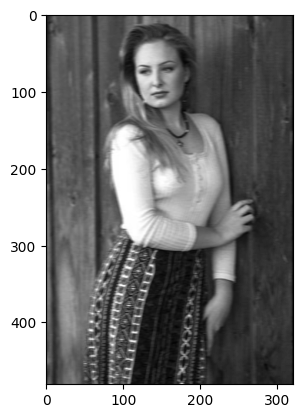

In [ ]:
plt.imshow(Ix, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

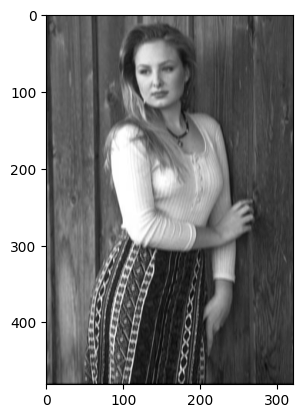

In [ ]:
plt.imshow(Iy, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

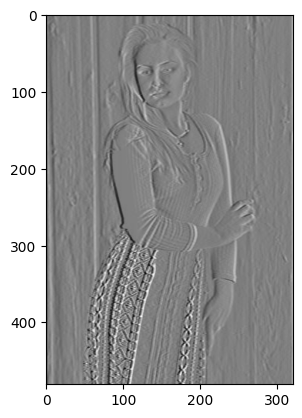

In [ ]:
plt.imshow(Ixprime, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

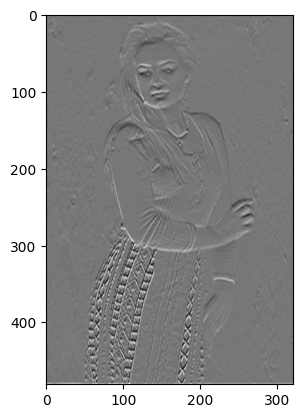

In [ ]:
plt.imshow(Iyprime, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

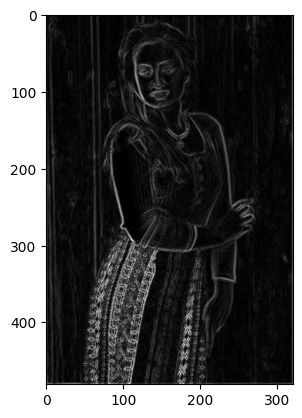

In [ ]:
mag = magnitude(Ixprime, Iyprime)
plt.imshow(mag, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

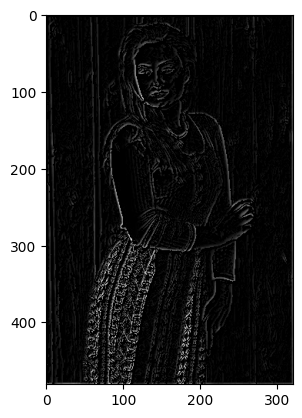

In [ ]:
theta = orientation(Ixprime, Iyprime)
nms = non_max_suppression(theta, mag)
plt.imshow(nms, cmap='gray')
plt.show

[[  0.   0.   0. ...   0.   0.   0.]
 [  0. 255.   0. ...   0. 255. 255.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 255. 255.]
 [  0. 255.   0. ... 255. 255. 255.]
 [  0. 255. 255. ... 255. 255. 255.]]


<function matplotlib.pyplot.show(close=None, block=None)>

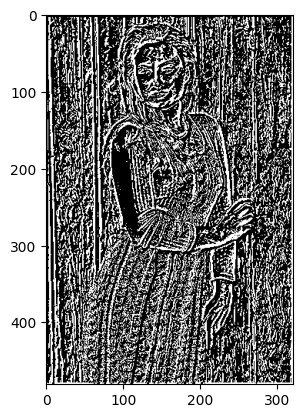

In [ ]:
canny_image = hysterisis_thresholding(nms)
plt.imshow(canny_image, cmap='gray')
plt.show

#Sigma=3

In [ ]:
G_2 = gaussian_kernel(4)
Gprime_2 = gaussian_derivative_kernel(4)

Ix_2, Iy_2 = convolution(I, G_2)
Ixprime_2, Iyprime_2 = convolution(I, Gprime_2)

<function matplotlib.pyplot.show(close=None, block=None)>

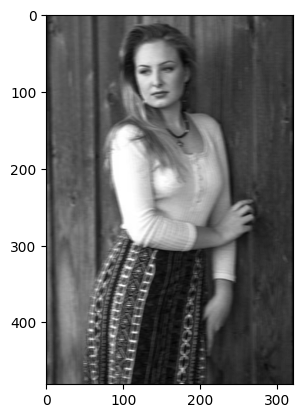

In [ ]:
plt.imshow(Ix_2, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

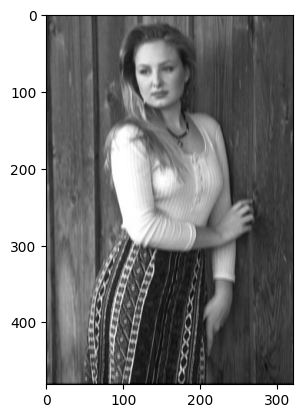

In [ ]:
plt.imshow(Iy_2, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

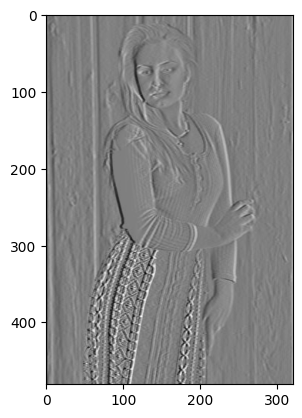

In [ ]:
plt.imshow(Ixprime_2, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

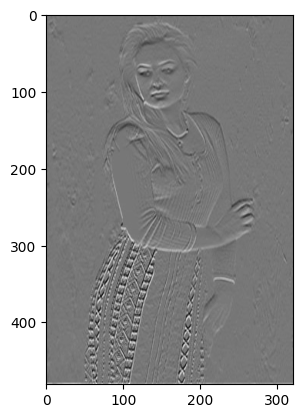

In [ ]:
plt.imshow(Iyprime_2, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

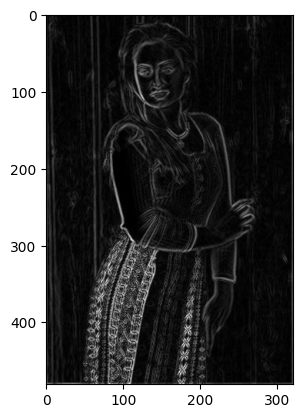

In [ ]:
mag_2 = magnitude(Ixprime_2, Iyprime_2)
plt.imshow(mag_2, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

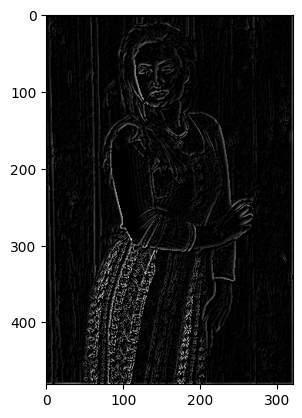

In [ ]:
theta_2 = orientation(Ixprime_2, Iyprime_2)
nms_2 = non_max_suppression(theta_2, mag_2)
plt.imshow(nms_2, cmap='gray')
plt.show

[[  0.   0.   0. ...   0.   0.   0.]
 [  0. 255.   0. ...   0. 255. 255.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 255. 255.]
 [  0. 255.   0. ... 255. 255. 255.]
 [  0. 255. 255. ... 255. 255. 255.]]


<function matplotlib.pyplot.show(close=None, block=None)>

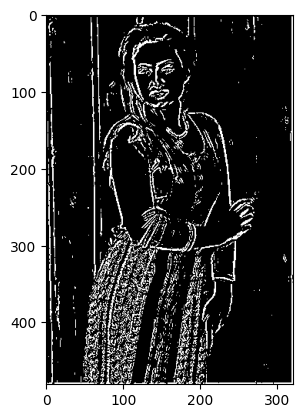

In [ ]:
canny_image2 = hysterisis_thresholding(nms_2)
plt.imshow(canny_image2, cmap='gray')
plt.show

#Sigma = 6

In [ ]:
G_3 = gaussian_kernel(6)
Gprime_3 = gaussian_derivative_kernel(6)

Ix_3, Iy_3 = convolution(I, G_3)
Ixprime_3, Iyprime_3 = convolution(I, Gprime_3)

<function matplotlib.pyplot.show(close=None, block=None)>

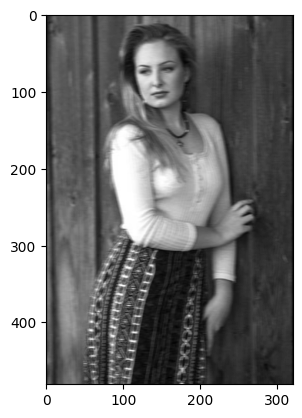

In [ ]:
plt.imshow(Ix_3, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

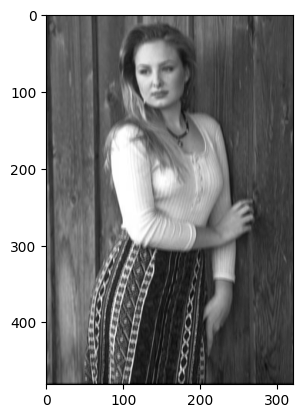

In [ ]:
plt.imshow(Iy_3, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

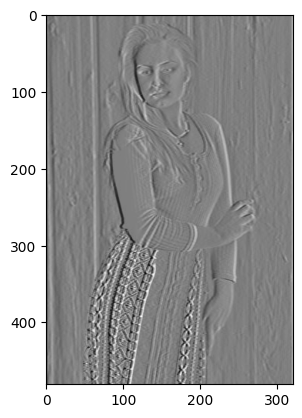

In [ ]:
plt.imshow(Ixprime_3, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

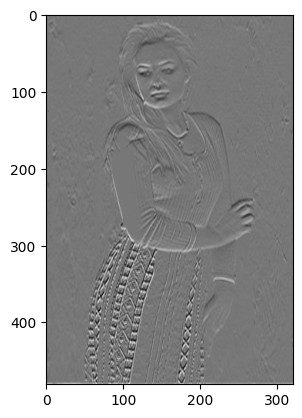

In [ ]:
plt.imshow(Iyprime_3, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

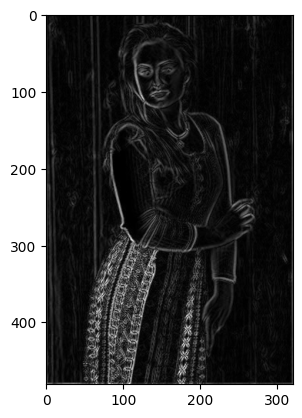

In [ ]:
mag_3 = magnitude(Ixprime_3, Iyprime_3)
plt.imshow(mag_3, cmap='gray')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

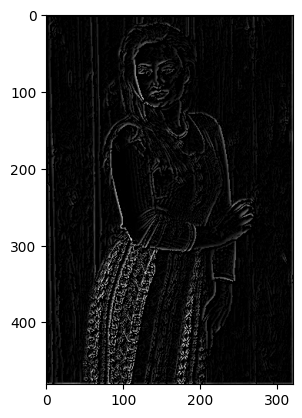

In [ ]:
theta_3 = orientation(Ixprime_3, Iyprime_3)
nms_3 = non_max_suppression(theta_3, mag_3)
plt.imshow(nms_3, cmap='gray')
plt.show

[[  0.   0.   0. ...   0.   0.   0.]
 [  0. 100.   0. ...   0. 100. 100.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0. 100.]
 [  0. 255.   0. ...   0. 100. 100.]
 [  0. 255. 255. ... 100. 100. 100.]]


<function matplotlib.pyplot.show(close=None, block=None)>

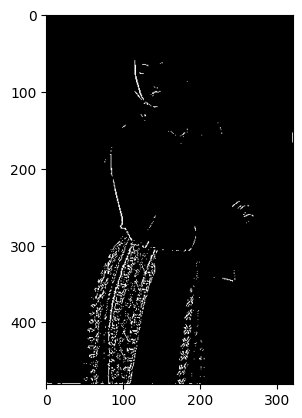

In [ ]:
canny_image3 = hysterisis_thresholding(nms_3)
plt.imshow(canny_image3, cmap='gray')
plt.show